### **Section 5.6 - Ablation Study**

In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
from imblearn.pipeline import Pipeline
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
import warnings
import tensorflow
import keras
import re
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from imblearn.over_sampling import RandomOverSampler

from lab_v2.io import read_file

tensorflow.random.set_seed(0)

tensorflow.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

In [50]:
ATTRIBUTES = ["majority_distance", "majority_distance_squared", "shannon_entropy", "gini_impurity"]
CLASS = 'majority_correct'
RANDOM_STATE = 42

In [51]:
def cross_val_metrics(classifier, X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    recalls = []
    precisions = []
    f1_scores = []
    auprcs = []
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        classifier.fit(X_train_fold, y_train_fold)
        y_pred_fold = classifier.predict(X_test_fold)

        recalls.append(recall_score(y_test_fold, y_pred_fold, pos_label=0))
        precisions.append(precision_score(y_test_fold, y_pred_fold, pos_label=0))
        f1_scores.append(f1_score(y_test_fold, y_pred_fold, pos_label=0))
        accuracies.append(accuracy_score(y_test_fold, y_pred_fold))

        y_prob_fold = classifier.predict_proba(X_test_fold)[:, 0]
        precision_fold, recall_fold, _ = precision_recall_curve(y_test_fold, y_prob_fold, pos_label=0)
        auprcs.append(auc(recall_fold, precision_fold))

    return np.mean(recalls), np.mean(precisions), np.mean(f1_scores), np.mean(auprcs), np.mean(accuracies)


In [52]:
class MLExploration:
    def __init__(self, data_x, data_y, output_file_path):
        self.data_x = data_x
        self.data_y = data_y
        self.output_file_path = output_file_path
        self.explored_models = pd.DataFrame()
        self.results = {}
        if os.path.exists(output_file_path):
            self.explored_models = pd.read_json(output_file_path, lines=True)

    def explore_model(self, clf_func, sampler, exclude_combinations=[]):
        if os.path.isfile(self.output_file_path):
            self.explored_models = read_file(self.output_file_path)
            for ind in self.explored_models.index:
                self.plot_ablation_study_results(None, self.explored_models["exclude_attrs"][ind], self.explored_models["recall"][ind], self.explored_models["precision"][ind], self.explored_models["f1"][ind], self.explored_models["auprc"][ind], self.explored_models["accuracy"][ind])
            return
            
        for exclude_attrs in [None] + exclude_combinations:
            if exclude_attrs:
                data_x_ablation = self.data_x.drop(columns=exclude_attrs)
            else:
                data_x_ablation = self.data_x

            remaining_feats = data_x_ablation.shape[1]  # Calculate remaining features based on the data

            clf = clf_func(remaining_feats)

            clf_hash = self.__hash_model(clf)
            sampler_hash = self.__hash_model(sampler)
            index = str((clf_hash, sampler_hash, exclude_attrs))

            if (
                "id" in self.explored_models.columns
                and (self.explored_models["id"].eq(index)).any()
            ):
                continue

            if sampler == None:
                model = clf
            else:
                model = Pipeline([("sampler", sampler), ("clf", clf)])

            recall, precision, f1, auc_score, accuracy = cross_val_metrics(
                model, data_x_ablation, self.data_y
            )

            self.plot_ablation_study_results(
                clf, exclude_attrs, recall, precision, f1, auc_score, accuracy
            )

            row = pd.DataFrame(
                [
                    {
                        "id": index,
                        "clf": clf_hash,
                        "sampler": sampler_hash,
                        "exclude_attrs": exclude_attrs,
                        "recall": recall,
                        "precision": precision,
                        "f1": f1,
                        "auprc": auc_score,
                        "accuracy": accuracy
                    }
                ]
            )
            self.explored_models = pd.concat([self.explored_models, row])
            self.explored_models.to_json(
                self.output_file_path, lines=True, orient="records"
            )

    def plot_ablation_study_results(
        self, clf, exclude_attrs, recall, precision, f1, auc_score, accuracy
    ):
        if exclude_attrs is None:
            label = "All features"
        else:
            exclude_mapping = {
                ("shannon_entropy",): "Entropy\n(removed)",
                ("gini_impurity",): "Gini Impurity\n(removed)",
                (
                    "shannon_entropy",
                    "gini_impurity",
                ): "Entropy,\nGini Impurity\n(removed)",
                ("majority_distance",): "remove",
                ("majority_distance_squared",): "remove",
                (
                    "majority_distance",
                    "majority_distance_squared",
                ): "Centroid Distance\n(removed)",
            }
            label = exclude_mapping.get(
                tuple(exclude_attrs), f"{'& '.join(exclude_attrs)} (removed)"
            )

            if label == "remove": return

        self.results[label] = [recall, precision, f1, auc_score, accuracy]

    def plot_summary(self, dataset):
        labels = list(self.results.keys())
        recall = [self.results[label][0] for label in labels]
        precision = [self.results[label][1] for label in labels]
        f1 = [self.results[label][2] for label in labels]
        auc_score = [self.results[label][3] for label in labels]
        accuracy = [self.results[label][4] for label in labels]

        df = pd.DataFrame(
            [
                {
                    "label": labels[i],
                    "recall": recall[i],
                    "precision": precision[i],
                    "f1": f1[i],
                    "auc_score": auc_score[i],
                    "accuracy": accuracy[i],
                }
                for i in range(len(labels))
            ]
        )

        out_path = self.output_file_path.split("/")[:-1]
        out_path = "/".join(out_path)
        df.to_json(
            f"{out_path}/results.jsonl", orient="records", lines=True
        )
        x = np.arange(len(labels))
        width = 0.1
        spacing_between_groups = 0.2  

        x = np.arange(0, len(labels) * (5 * width + spacing_between_groups), 5 * width + spacing_between_groups)

        fig, ax = plt.subplots(figsize=(12, 8))

        ax.bar(
            x - width * 2,
            accuracy,
            width,
            label="Accuracy (overall)",
            color="white",
            edgecolor="black",
            zorder=1
        )
        ax.bar(
            x - width * 1,
            recall,
            width,
            label="Recall (incorrect)",
            color="white",
            hatch="//",
            edgecolor="black",
            zorder=1
        )
        ax.bar(
            x,
            precision,
            width,
            label="Precision (incorrect)",
            color="black",
            edgecolor="black",
            zorder=1
        )
        ax.bar(
            x + width,
            f1,
            width,
            label="F1 (incorrect)",
            hatch="..",
            color="dimgray",
            edgecolor="black",
            zorder=1
        )
        ax.bar(
            x + width * 2,
            auc_score,
            width,
            label="AUPRC (incorrect)",
            hatch="--",
            color="lightgray",
            edgecolor="black",
            zorder=1
        )

        ax.set_ylabel(f"Performance ({dataset})", fontsize=18, weight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(
            labels, ha="center", fontsize=14
        )  
        ax.tick_params(axis='y', labelsize=14)

        ax.legend(fontsize=13)

        # plt.ylim([0, 1])
        plt.yticks(np.arange(0, 1.1, 0.2))
        ax.yaxis.grid(True, linestyle="-", zorder=0)

        plt.tight_layout()  
        plt.show()

    def __dict_mean(self, obj):
        try:
            return sum(obj) / len(obj)
        except:
            return {
                key.replace("test_", ""): self.__dict_mean(obj[key])
                for key in obj.keys()
            }

    def __hash_model(self, clf):
        if type(clf) == KerasClassifier:
            cleaned = re.sub(r"\n\tmodel\=.*\n", "", str(clf), re.DOTALL)
            cleaned = re.sub(r"\n", ",", cleaned, re.DOTALL)
            cleaned = re.sub(r"\t", "", cleaned, re.DOTALL)
            return str((cleaned, self.__keras_model_info(clf)))
        return str(clf)

    def __keras_model_info(self, clf):
        return str(
            [
                (type(layer).__name__, layer.units, layer.activation.__name__)
                for layer in clf.model.layers
            ]
        )

In [53]:
def create_model(n_features, n_layers, units, hidden_activation, output_activation, step_size=2):
    model = Sequential()
    step = -step_size
    for i in range(n_layers):
        if i == 0:
            model.add(Dense(units, input_dim=n_features, activation=hidden_activation)) 
            # model.add(Dropout(dropout_rate))  # dropout layer
 
        else:
            if step == 0: units = max(1, units // 2)
            model.add(Dense(units, activation=hidden_activation))
            # model.add(Dropout(dropout_rate))  # Add dropout layer after each Dense layer

        step = (step + 1) % step_size

    model.add(Dense(1, activation=output_activation))   
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [54]:
exclude_features = [['shannon_entropy'], ['gini_impurity'], ['shannon_entropy', 'gini_impurity'], ['majority_distance', 'majority_distance_squared']]

In [55]:
def create_classifier(remaining_feats):
    return KerasClassifier(
        model=create_model(remaining_feats, 10, 100, 'relu', 'sigmoid', step_size=2),
        verbose=0,
        epochs=100,
        batch_size=128
    )

DATASET:  DRAW-1K


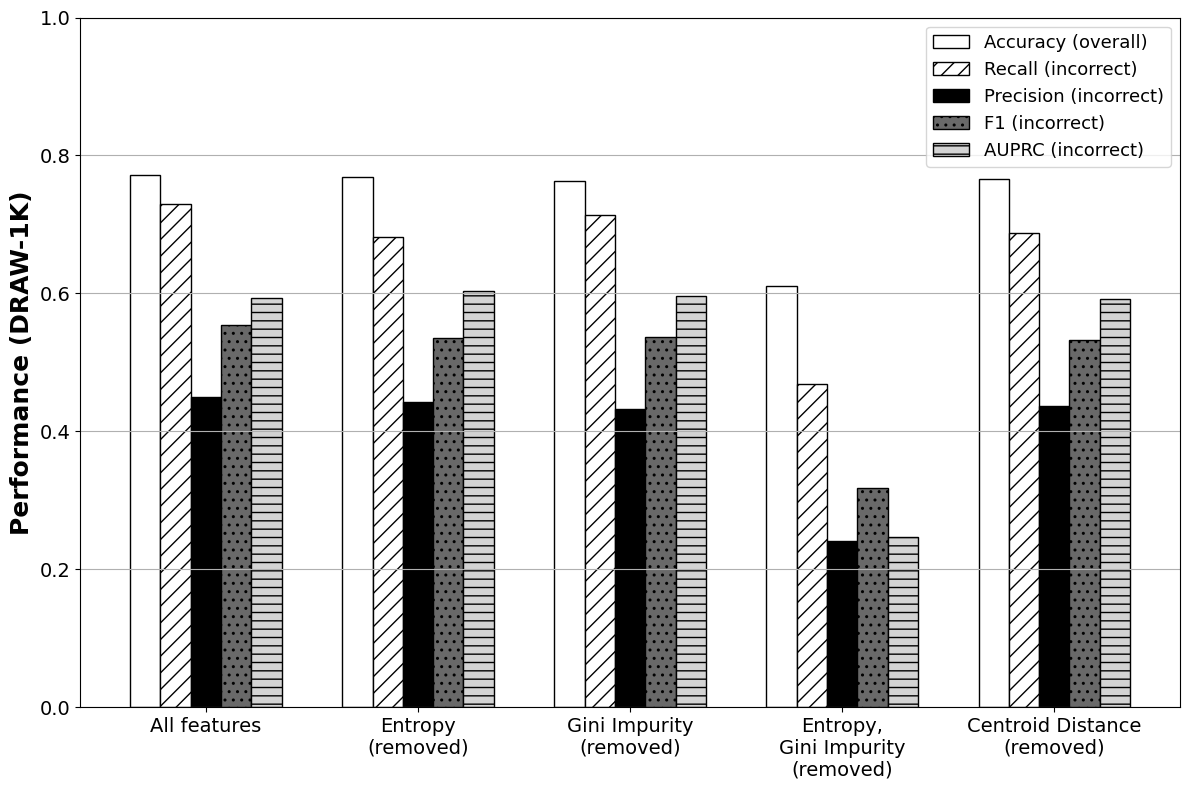

DATASET:  CSQA


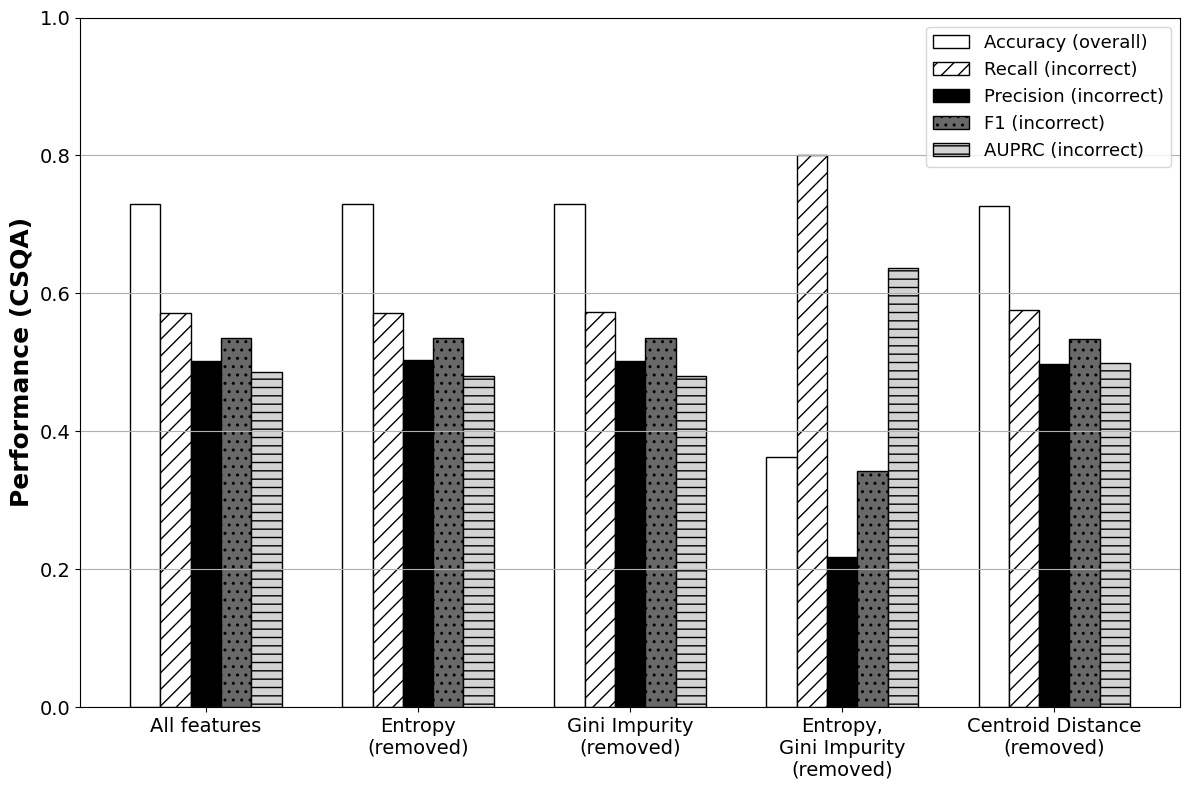

DATASET:  LAST LETTERS


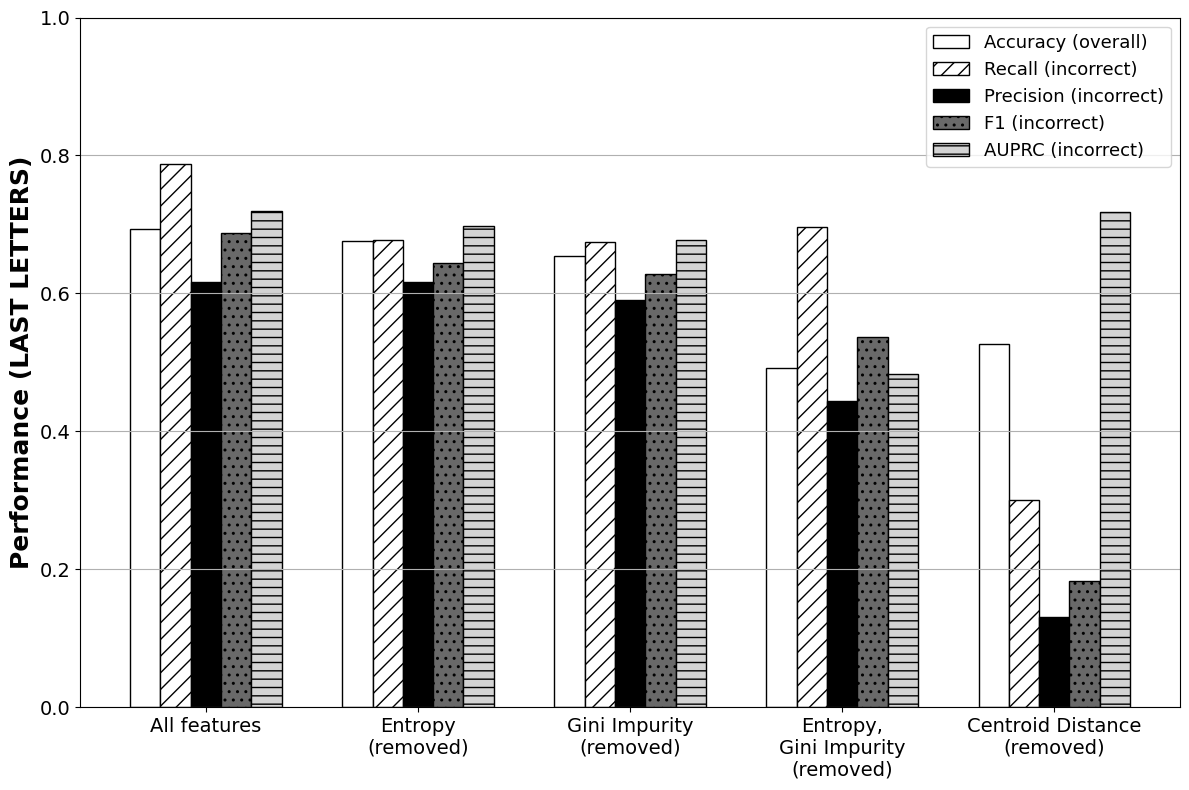

DATASET:  SVAMP


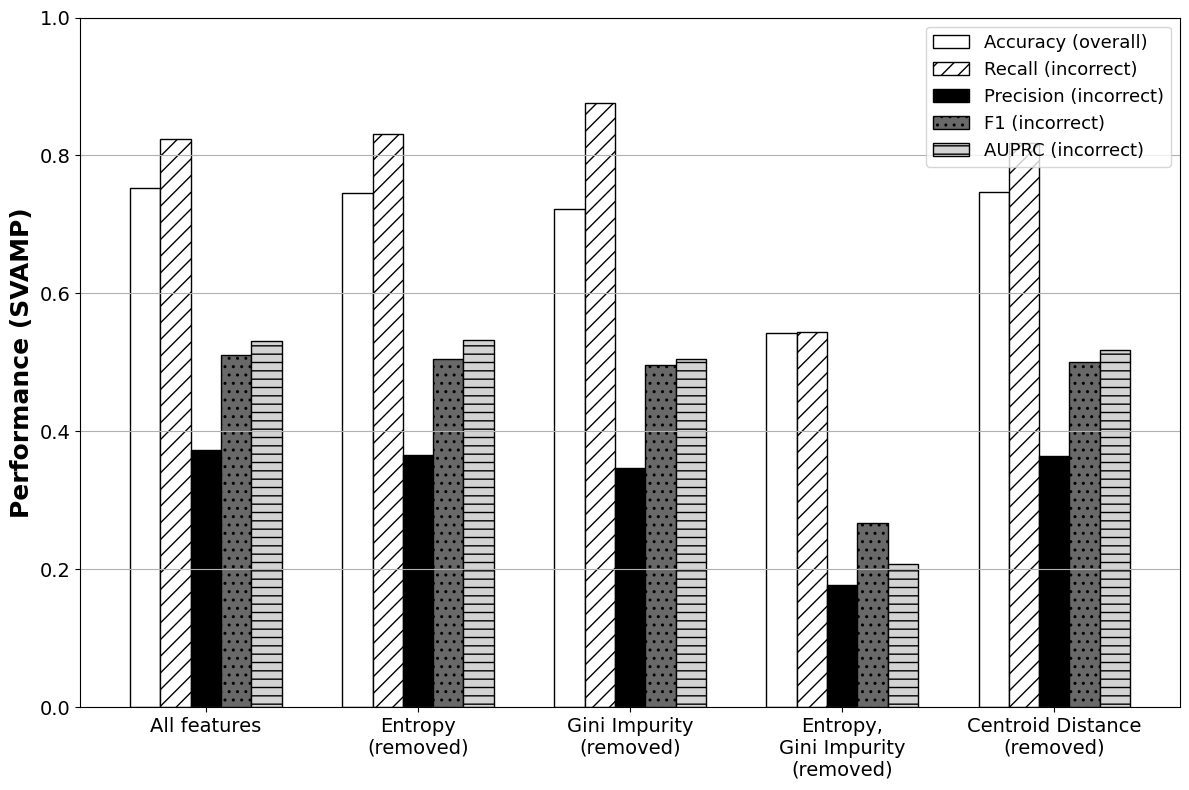

DATASET:  STRATEGYQA


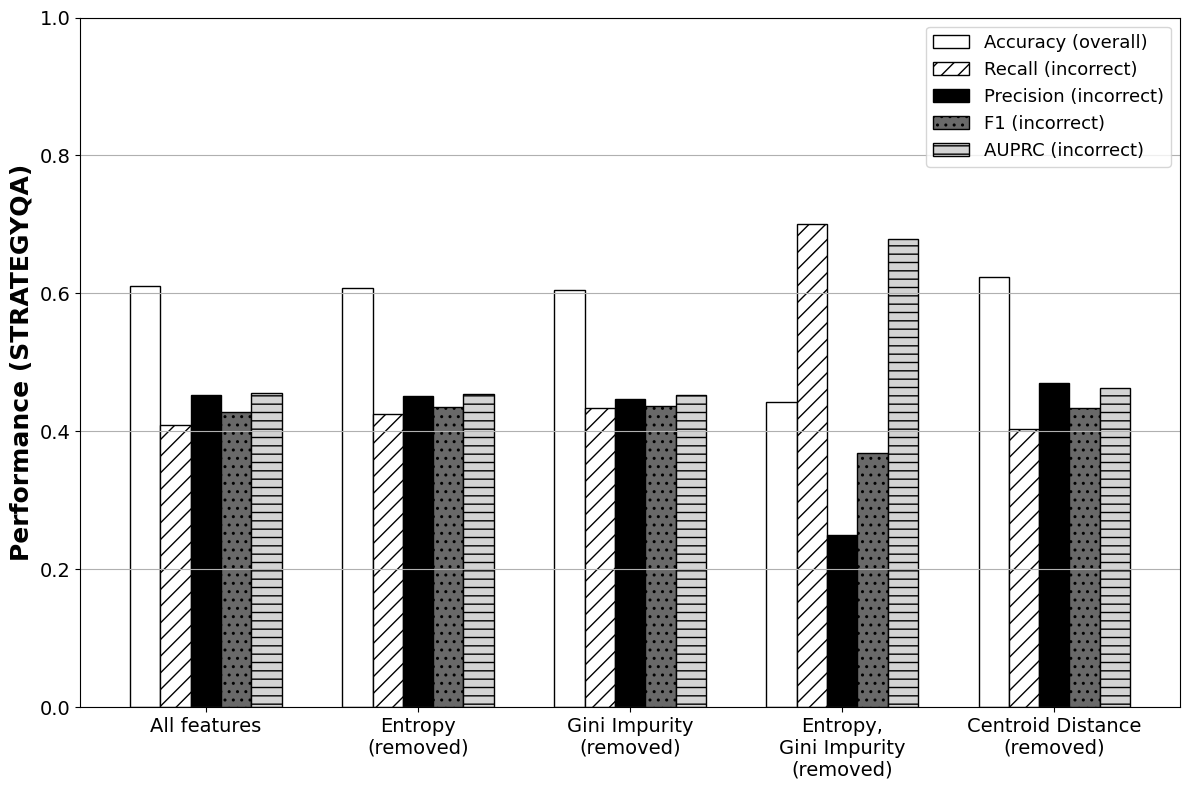

In [56]:
for file_path, cache_file_path, dataset in [
    ('../../data/machine-learning/base-T0.7/draw.jsonl', '../../cache/ablation/base-T0.7/draw.jsonl', 'DRAW-1K'),
    ('../../data/machine-learning/base-T0.7/csqa.jsonl', '../../cache/ablation/base-T0.7/csqa.jsonl', 'CSQA'),
    ('../../data/machine-learning/base-T0.7/last_letters.jsonl', '../../cache/ablation/base-T0.7/last_letters.jsonl', 'LAST LETTERS'),
    ('../../data/machine-learning/base-T0.7/svamp.jsonl', '../../cache/ablation/base-T0.7/svamp.jsonl', 'SVAMP'),
    ('../../data/machine-learning/base-T0.7/strategyQA.jsonl', '../../cache/ablation/base-T0.7/strategyQA.jsonl', 'STRATEGYQA'),

]:
    print('DATASET: ', dataset)
    data = pd.read_json(file_path, lines=True)
    data_x = data[ATTRIBUTES]
    data_y = data[CLASS]

    ml_exploration = MLExploration(
        data_x=data_x, data_y=data_y, output_file_path=cache_file_path
    )

    ml_exploration.explore_model(
        clf_func=create_classifier,
        sampler=RandomOverSampler(random_state=0),
        exclude_combinations=exclude_features 
    )

    # Plot summary after exploring all combinations for the current dataset
    ml_exploration.plot_summary(dataset)